# Transfer Learning 

Jimmy Gardner 
Metis 21'

In [121]:
import os
from pathlib import Path
import shutil as sh
import pandas as pd

import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# activation to softmax
# loss to catergorical cross entropy 
from keras import models
from keras import layers
from keras import optimizers
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

In [122]:
siberian_stock = '/Users/jamesgardner/Desktop/ConvolutionalNN/Siberian_Binary'
scottish_stock = '/Users/jamesgardner/Desktop/ConvolutionalNN/Scottish_Binary'

base_directory = '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_new_Binary'
os.mkdir(base_directory)


In [124]:
# train directory
train = os.path.join(base_directory,'train')
os.mkdir(train)

# val directory
val = os.path.join(base_directory,'validation')
os.mkdir(val)

# test directory
test = os.path.join(base_directory,'test')
os.mkdir(test)



In [125]:
# defining function for making train_val_test directories for each class
def make_train_val_test(sub_directories,ttv_directiories,directory_names):
    '''
    
    Output: train, validation , and test directories for each class
    
    sub_directories: list of names for each class
    ttv_directories: train,test,split file paths
    directory_names: name for each class directory splits
    '''
    
    file_names = []
    for i in range(2):
        file_names_class = []
        for j in range(len(ttv_directories)):
            directory_names[i][j] = os.path.join(ttv_directories[j],sub_directories[i])
            os.mkdir(directory_names[i][j])
            file_names_class.append(directory_names[i][j])
        file_names.append(file_names_class)
    
    return file_names

In [126]:
def distribute_images(file_names,bas_dir):
    
    '''
    Distributing images to each train, validation, and test directories for each class
    
    file_names: directories to put images in 
    base_dir: path to directories 
    
    '''
    
    for i in range(len(bas_dir)):
        parent_list = os.listdir(base_dir[i])
        count=0
    
        for child in parent_list:
            if count<1200:
        
            # /Users/jamesgardner/Desktop/ConvolutionalNN/Siberian/siberian0.jpg
                src = os.path.join(base_dir[i], child)
                dst = os.path.join(file_names[i][0], child)
                sh.copyfile(src, dst)
            
            elif count >= 1200 and count <1600:
                src = os.path.join(base_dir[i], child)
                dst = os.path.join(file_names[i][1], child)
                sh.copyfile(src, dst)
            
            elif count >= 1600 and count <2000:
                src = os.path.join(base_dir[i], child)
                dst = os.path.join(file_names[i][2], child)
                sh.copyfile(src, dst)
       
            count += 1 

In [127]:
# defining lists for use in make_train_val_test
# add class name to sub_directories and directory_names if you want to extend to multi-class
sub_directories = ['SF','SB']
ttv_directories = [train,val,test]
directory_names = [['train_scottish','val_scottish','test_scottish'],
                   ['train_siberian','val_siberian','test_siberian']]
base_dir = [scottish_stock,siberian_stock]

file_names = make_train_val_test(sub_directories,ttv_directories,directory_names)
distribute_images(file_names,base_dir)

# Feature Extraction

Defining Base Convolutional Network 

1.VGG16

2.InceptionV3

3.Feature Extraction



In [254]:
import keras
keras.__version__
from tensorflow.keras.applications import VGG16,InceptionV3


# defining convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base_2 = InceptionV3(weights = 'imagenet',
                         include_top = False,
                         input_shape = (299, 299, 3))


In [258]:
# change shape annd target_size depending on convolutional bae 
# add to shape = (sample_count,however many classes)
# change class_mode to 'catergorical'
# pass through conv_base so we can run more pretrained bases 
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 19
def extract_features(directory, sample_count,conv_base):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)
    
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    
    return features, labels, generator

train_features, train_labels,generator_train = extract_features(train, 2398,conv_base_2)
validation_features, validation_labels,generator_val = extract_features(val, 800,conv_base_2)
test_features, test_labels,generator_test = extract_features(test, 800,conv_base_2)


Found 2398 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 799 images belonging to 2 classes.


# Feature Extraction for Image Augmentation

In [230]:
# defining imageDataGenerator for train set
datagen_2 = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.5,
      height_shift_range=0.4,
      shear_range=0.3,
      zoom_range=0.7,
      horizontal_flip=True,
      fill_mode='nearest')

batch_size = 20


In [231]:
# extracting features using augmented images 
batch_size = 20

def extract_features_2(directory,sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen_2.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)
    
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    
    return features, labels, generator

In [232]:
aug_features,aug_labels,aug_generator = extract_features_2(train,2398)

Found 2398 images belonging to 2 classes.


# Reshaping for model use

In [261]:
train_features = np.reshape(train_features, (2398, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (800, 8* 8 * 2048))
test_features = np.reshape(test_features, (800, 8 * 8 * 2048))
aug_features = np.reshape(aug_features,(2398,4*4*512))

# Running Model (Transfer Learning)

In [262]:

model_5 = models.Sequential()
#model_5.add(Conv2D(64, kernel_size=3, activation='relu', input_dim=4*4*512))
model_5.add(layers.Dense(256, activation='relu', input_dim=8 * 8 * 2048))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(1, activation='sigmoid'))
# change units to number of classes 
#model_5.add(Dense(units=3,activation="softmax"))

# for loss use 'catergorical_crossentropy'
model_5.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model_5.fit(train_features, train_labels,
                    epochs=55,
                    batch_size=19,
                    validation_data=(test_features, test_labels))

Epoch 1/55
127/127 [==============================] - 35s 256ms/step - loss: 0.7942 - acc: 0.6844 - val_loss: 0.6228 - val_acc: 0.7300
Epoch 2/55
127/127 [==============================] - 29s 227ms/step - loss: 0.2540 - acc: 0.8877 - val_loss: 0.2932 - val_acc: 0.8788
Epoch 3/55
127/127 [==============================] - 28s 223ms/step - loss: 0.1392 - acc: 0.9471 - val_loss: 0.4947 - val_acc: 0.8450
Epoch 4/55
127/127 [==============================] - 29s 224ms/step - loss: 0.1005 - acc: 0.9585 - val_loss: 0.2211 - val_acc: 0.9200
Epoch 5/55
127/127 [==============================] - 29s 226ms/step - loss: 0.0678 - acc: 0.9754 - val_loss: 0.2094 - val_acc: 0.9325
Epoch 6/55
127/127 [==============================] - 29s 225ms/step - loss: 0.0537 - acc: 0.9795 - val_loss: 0.1988 - val_acc: 0.9388
Epoch 7/55
127/127 [==============================] - 28s 223ms/step - loss: 0.0420 - acc: 0.9851 - val_loss: 0.1930 - val_acc: 0.9325
Epoch 8/55
127/127 [==============================] - 2

In [263]:
#accuracy = model_5.evaluate(x=validation_features,y=validation_labels,batch_size=32)
#print("Accuracy: ", accuracy[1])

accuracy = model_5.evaluate(x=validation_features,y=validation_labels,batch_size=32)
print("Accuracy Test: ", accuracy[1])

25/25 [==============================] - 1s 24ms/step - loss: 0.4514 - acc: 0.9400
Accuracy Test:  0.9399999976158142


# Results Analysis

In [268]:
test_files = generator_test.filenames
CLASS_PAIR = []
for i in range(len(test_files)):
    IMG = validation_features[i]
    LABEL = validation_labels[i]
    TEST_IMG = IMG.reshape((1,131072))
    IMG_CLASS = model_5.predict_classes(TEST_IMG)
    #model_2.predict_classes(test_img)
    MAP_CLASS = {0:'Siberian',1:'Scottish'}
    PREDICTION = IMG_CLASS[0][0]
    VAL_SET_ORIGINAL = val_files[i]
    PAIR = (PREDICTION,LABEL,VAL_SET_ORIGINAL)
    CLASS_PAIR.append(PAIR)
   

In [269]:
# looking up class indices
generator_test.class_indices


{'SB': 0, 'SF': 1}

In [270]:
# making data frame for classification results 
import pandas as pd
BINARY_RESULTS = pd.DataFrame(CLASS_PAIR, columns = {'Prediction','Actual','FileName'})


In [271]:
# renaming columns
BINARY_RESULTS.rename(columns={'Prediction': 'Actual', 'FileName': 'Prediction','Actual':'FileName'}, inplace=True)


In [273]:
# making masks for confusion matrix 
BINARY_RESULTS.sample(50)
correct_scottish = (BINARY_RESULTS['Actual'] == 1) & (BINARY_RESULTS['Prediction'] == 1.0)
correct_siberian = (BINARY_RESULTS['Actual'] == 0) & (BINARY_RESULTS['Prediction'] == 0.0)
actually_siberian = (BINARY_RESULTS['Actual'] == 0) & (BINARY_RESULTS['Prediction'] == 1.0)
actually_scottish = (BINARY_RESULTS['Actual'] == 1) & (BINARY_RESULTS['Prediction'] == 0.0)

In [274]:
Actually_Siberian = BINARY_RESULTS[actually_siberian]
Actually_Siberian.reset_index(inplace=True,drop=True)


Actually_Scottish = BINARY_RESULTS[actually_scottish]
Actually_Scottish.reset_index(inplace=True,drop=True)

Correct_Scottish = BINARY_RESULTS[correct_scottish]
Correct_Scottish.reset_index(inplace=True,drop=True)

Correct_Siberian = BINARY_RESULTS[correct_siberian]
Correct_Siberian.reset_index(inplace=True,drop=True)


In [281]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image


# predicted scottish fold, should be siberian 
def Act_Siberian(df,file_loc):
    shp = df.shape
    for i in range(shp[0]-15):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/{}/{}'.format(file_loc,df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()
    
def Act_Scottish(df,file_loc):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/{}/{}'.format(file_loc,df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()

# predicted Scottish , was actually scottish 
def Crct_Scottish(df,file_loc):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/{}/{}'.format(file_loc,df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()
    
# predicted Siberian was actually Siberian 
def Crct_Siberian(df,file_loc):
    shp = df.shape
    for i in range(shp[0]):
        img_path =  '/Users/jamesgardner/Desktop/ConvolutionalNN/Splts_Binary/{}/{}'.format(file_loc,df['FileName'][i])
        img = image.load_img(img_path, target_size=(512, 512))
        plt.imshow(img)
        print(df['FileName'][i])
        plt.show()
    
    


    
    
    
file_location = 'test'

In [106]:
# Predicted Scottish Fold , but was actually siberian 
Act_Siberian(Actually_Siberian,file_location)

# Predicted Siberian but was actually Scottish Fold
Act_Scottish(Actually_Scottish,file_location)

# Predicted Siberian and was Actually Siberian 
Crct_Siberian(Correct_Siberian,file_location)

Crct_Scottish(Correct_Scottish,file_location)

SB/siberian1174.jpg


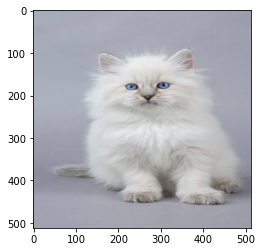

SB/siberian1215.jpg


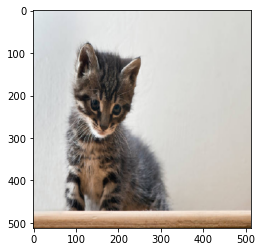

SB/siberian1216.jpg


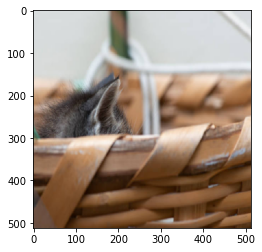

SB/siberian1298.jpg


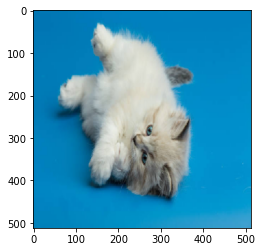

SB/siberian1363.jpg


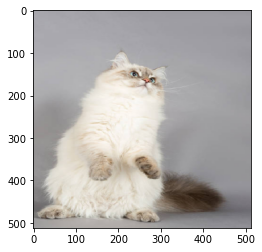

SB/siberian1405.jpg


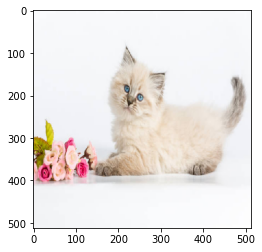

SB/siberian1598.jpg


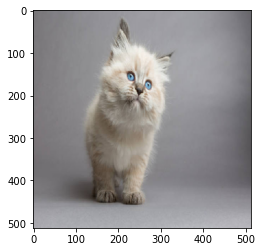

In [282]:
# Predicted Scottish Fold , but was actually siberian 
Act_Siberian(Actually_Siberian,file_location)

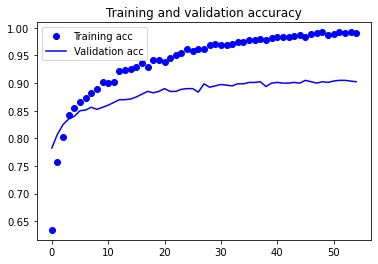

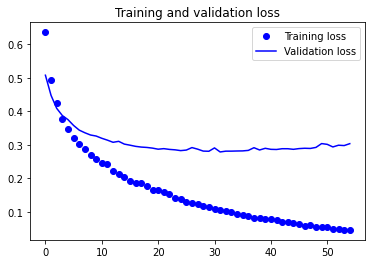

In [169]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Image Augmentation 

In [234]:
model_6 = models.Sequential()
#model_5.add(Conv2D(64, kernel_size=3, activation='relu', input_dim=4*4*512))
model_6.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(1, activation='sigmoid'))
# change units to number of classes 
#model_5.add(Dense(units=3,activation="softmax"))

# for loss use 'catergorical_crossentropy'
model_6.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model_6.fit(aug_features, aug_labels,
                    epochs=55,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/55
120/120 [==============================] - 2s 10ms/step - loss: 0.7455 - acc: 0.5244 - val_loss: 0.6154 - val_acc: 0.6837
Epoch 2/55
120/120 [==============================] - 1s 9ms/step - loss: 0.6675 - acc: 0.6022 - val_loss: 0.5660 - val_acc: 0.7088
Epoch 3/55
120/120 [==============================] - 1s 9ms/step - loss: 0.6182 - acc: 0.6580 - val_loss: 0.5355 - val_acc: 0.7412
Epoch 4/55
120/120 [==============================] - 1s 9ms/step - loss: 0.5994 - acc: 0.6710 - val_loss: 0.5153 - val_acc: 0.7550
Epoch 5/55
120/120 [==============================] - 1s 9ms/step - loss: 0.5680 - acc: 0.7253 - val_loss: 0.5074 - val_acc: 0.7513
Epoch 6/55
120/120 [==============================] - 1s 9ms/step - loss: 0.5591 - acc: 0.7101 - val_loss: 0.4941 - val_acc: 0.7563
Epoch 7/55
120/120 [==============================] - 1s 8ms/step - loss: 0.5394 - acc: 0.7257 - val_loss: 0.4855 - val_acc: 0.7600
Epoch 8/55
120/120 [==============================] - 1s 8ms/step - loss: 0

# Testing images outside the data set
Model 5 : VGG16 Base ---> Densely connected network

In [242]:
test_generator.reset()
pets_features,pets_labels,test_generator = extract_features('/Users/jamesgardner/Desktop/Pets',2)


Found 2 images belonging to 2 classes.


In [243]:
# class indices are determined in alphabetical order
# make sure to remember this when adding another class 
# 1's and 0's based off original model 
files = test_generator.filenames
test_generator.class_indices


{'SB': 0, 'SF': 1}

In [248]:
# re_shaping and preparing for data frame 
ClassPair = []
for i in range(len(files)):
    IMG = pets_features[i]
    LABEL = pets_labels[i]
    TEST_IMG = IMG.reshape((1,8192))
    IMG_CLASS = model_5.predict_classes(TEST_IMG)
    PREDICTION = IMG_CLASS[0][0]
    PETS_FILES = files[i]

    Pear = (PREDICTION,LABEL,PETS_FILES)
    ClassPair.append(Pear)

In [249]:
ClassPair

[(0, 0.0, 'SB/GrayBoy.PNG'), (1, 1.0, 'SF/scottish2278.jpg')]

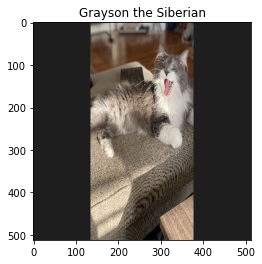

In [264]:
# Test set includes my cat Grayson. 
# Model correctly identifies him as a Siberian 
img_path =  '/Users/jamesgardner/Desktop/Pets/{}'.format('SB/GrayBoy.PNG')
img = image.load_img(img_path, target_size=(512, 512))
plt.imshow(img)
plt.title('Grayson the Siberian')
plt.show()
    